In [53]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge,Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
engine = author.raw_engine

In [54]:
df = pd.read_sql("SELECT * FROM BTCUSD_1h",engine)
df.set_index('Date',inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-03-05 15:00:00,9075.643555,9096.036133,9060.328125,9096.036133,9096.036133,0.000000e+00
2020-03-05 16:00:00,9094.782227,9124.201172,9091.835938,9105.301758,9105.301758,0.000000e+00
2020-03-05 17:00:00,9106.311523,9119.547852,9098.045898,9110.729492,9110.729492,2.937201e+08
2020-03-05 18:00:00,9111.915039,9123.532227,9101.458008,9120.463867,9120.463867,4.824269e+07
2020-03-05 19:00:00,9118.181641,9137.944336,9109.423828,9137.944336,9137.944336,3.094938e+07
...,...,...,...,...,...,...
2022-03-01 10:00:00,43227.777344,43473.699219,42983.214844,43473.699219,43473.699219,7.879721e+08
2022-03-01 11:00:00,43484.906250,43661.972656,43443.812500,43537.582031,43537.582031,8.142111e+08
2022-03-01 12:00:00,43542.511719,44543.996094,43542.511719,44543.996094,44543.996094,2.484015e+09


<AxesSubplot:>

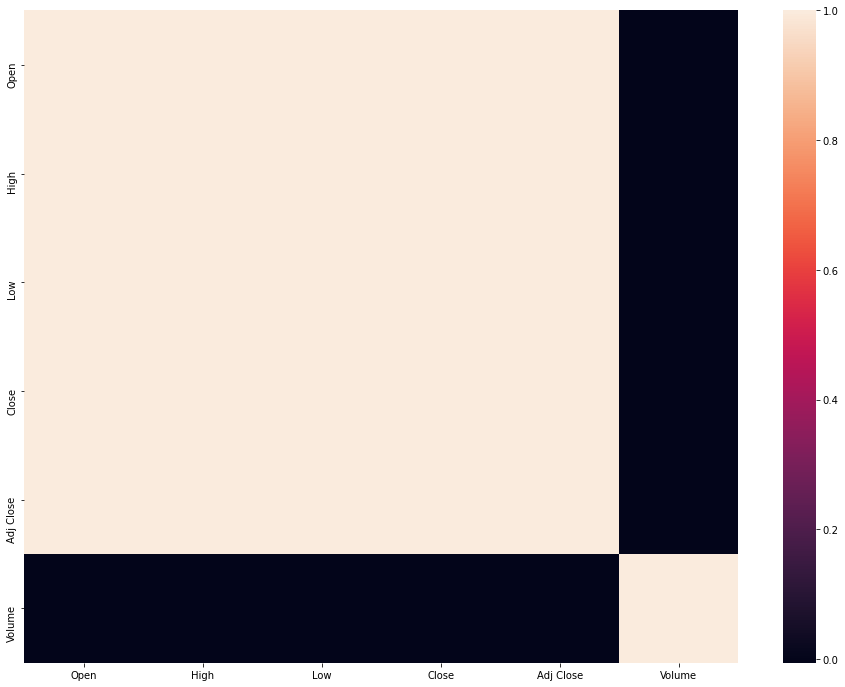

In [55]:
plt.figure(figsize=(16,12))
sns.heatmap(df.corr())

o,h,l,c는 실상 동일하므로 피쳐를 조합해 새로운 피쳐를 만들어준다.

In [56]:
gap = (df['High'] - df['Low'])
df['Gap'] = gap
df

,Open,High,Low,Close,Adj Close,Volume,Gap
Date,,,,,,,
2020-03-05 15:00:00,9075.643555,9096.036133,9060.328125,9096.036133,9096.036133,0.000000e+00,35.708008
2020-03-05 16:00:00,9094.782227,9124.201172,9091.835938,9105.301758,9105.301758,0.000000e+00,32.365234
2020-03-05 17:00:00,9106.311523,9119.547852,9098.045898,9110.729492,9110.729492,2.937201e+08,21.501953
2020-03-05 18:00:00,9111.915039,9123.532227,9101.458008,9120.463867,9120.463867,4.824269e+07,22.074219
2020-03-05 19:00:00,9118.181641,9137.944336,9109.423828,9137.944336,9137.944336,3.094938e+07,28.520508
...,...,...,...,...,...,...,...
2022-03-01 10:00:00,43227.777344,43473.699219,42983.214844,43473.699219,43473.699219,7.879721e+08,490.484375
2022-03-01 11:00:00,43484.906250,43661.972656,43443.812500,43537.582031,43537.582031,8.142111e+08,218.160156
2022-03-01 12:00:00,43542.511719,44543.996094,43542.511719,44543.996094,44543.996094,2.484015e+09,1001.484375


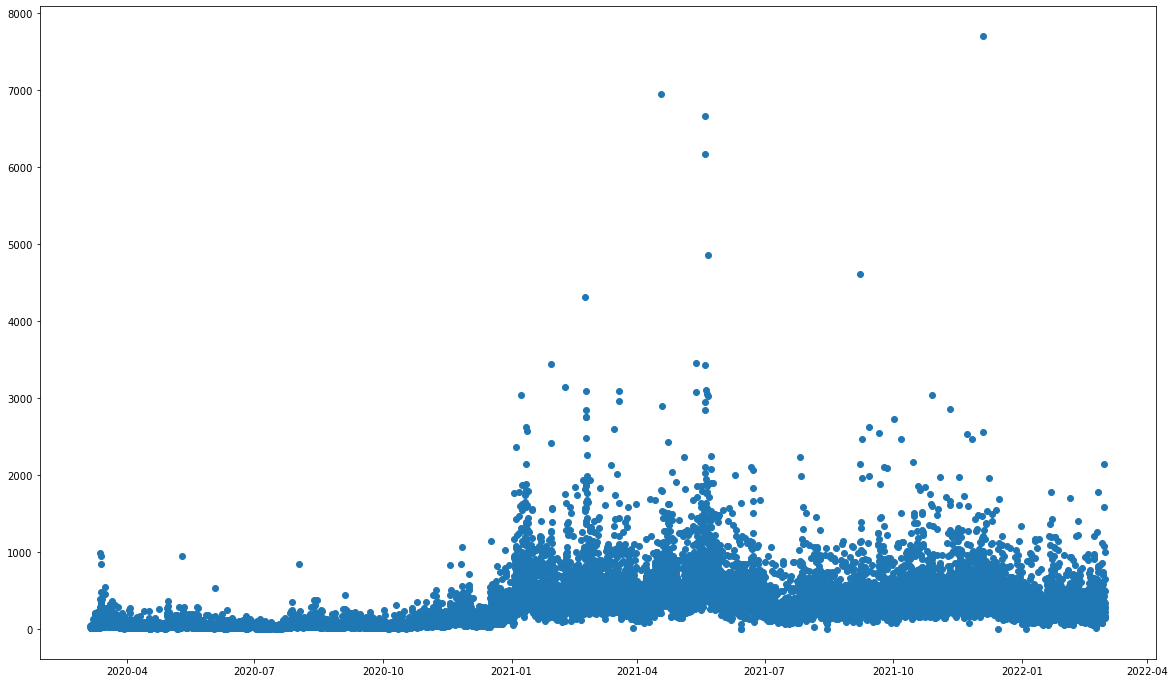

In [57]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

값이 커짐에 따라 변동폭도 증가하므로 명확한 아웃라이어를 보기위해 비트코인의 가격 상승을 반영해준다.

In [58]:
df['Gap'] = df['Gap'] / df['Low']

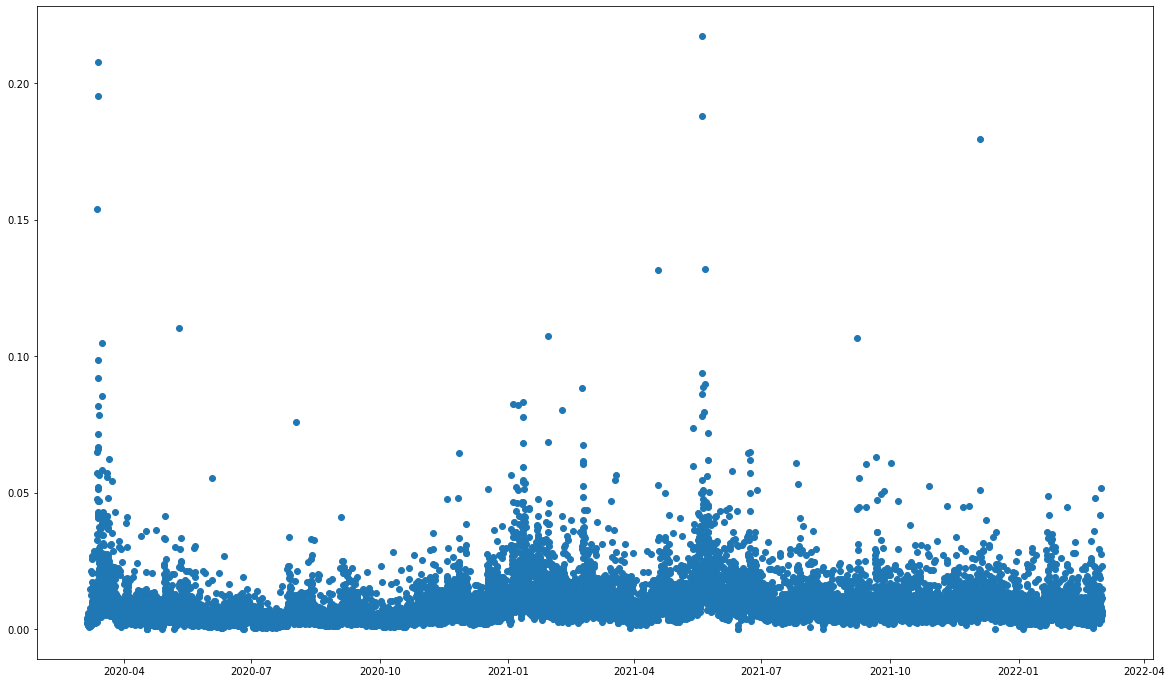

In [59]:
plt.figure(figsize=(20,12))
plt.scatter(df['Gap'].index, df['Gap'])

In [60]:
def get_macd(df):
    price = df['Adj Close']
    exp12 = price.ewm(span = 12, adjust=False).mean()
    exp26 = price.ewm(span = 26, adjust=False).mean()
    macd = exp12 - exp26
    exp = macd.ewm(span=9,adjust=False).mean()
    return exp

def get_rsi(df, period):
    close_price = df['Close']
    delta = close_price.diff()
    gains,drops = delta.copy(),delta.copy()
    gains[gains < 0] = 0
    drops[drops > 0] = 0
    au = gains.ewm(com=period-1, min_periods=period).mean()
    ad = drops.abs().ewm(com=period-1, min_periods=period).mean()
    rs = au / ad
    rsi = pd.Series(100 - (100 / (1 + rs)))
    return rsi

def get_vwap(df):
    volumes = df['Volume']
    price = df['Adj Close']
    vwap = ((volumes * price).cumsum()) / volumes.cumsum()
    return vwap

In [61]:
df['VWAP'] = get_vwap(df)
df['RSI'] = get_rsi(df,14)
df['MACD'] = get_macd(df)
df

,Open,High,Low,Close,Adj Close,Volume,Gap,VWAP,RSI,MACD
Date,,,,,,,,,,
2020-03-05 15:00:00,9075.643555,9096.036133,9060.328125,9096.036133,9096.036133,0.000000e+00,0.003941,NaN,NaN,0.000000
2020-03-05 16:00:00,9094.782227,9124.201172,9091.835938,9105.301758,9105.301758,0.000000e+00,0.003560,NaN,NaN,0.147828
2020-03-05 17:00:00,9106.311523,9119.547852,9098.045898,9110.729492,9110.729492,2.937201e+08,0.002363,9110.729492,NaN,0.466821
2020-03-05 18:00:00,9111.915039,9123.532227,9101.458008,9120.463867,9120.463867,4.824269e+07,0.002425,9112.102777,NaN,1.030617
2020-03-05 19:00:00,9118.181641,9137.944336,9109.423828,9137.944336,9137.944336,3.094938e+07,0.003131,9114.247465,NaN,1.994838
...,...,...,...,...,...,...,...,...,...,...
2022-03-01 10:00:00,43227.777344,43473.699219,42983.214844,43473.699219,43473.699219,7.879721e+08,0.011411,19785.683460,74.142861,1112.398909
2022-03-01 11:00:00,43484.906250,43661.972656,43443.812500,43537.582031,43537.582031,8.142111e+08,0.005022,19785.694793,74.637522,1093.406138
2022-03-01 12:00:00,43542.511719,44543.996094,43542.511719,44543.996094,44543.996094,2.484015e+09,0.023000,19785.730832,80.852259,1086.323296


In [62]:
df = df.dropna()
df = df.drop(['Open','Close','High','Low'], axis=1)
df


,Adj Close,Volume,Gap,VWAP,RSI,MACD
Date,,,,,,
2020-03-06 05:00:00,9100.071289,3.615334e+08,0.004717,9084.801055,53.776258,-4.959533
2020-03-06 06:00:00,9109.397461,9.780019e+07,0.003299,9085.905747,56.473186,-4.924357
2020-03-06 07:00:00,9108.590820,9.688678e+07,0.003117,9086.872084,56.167937,-4.451860
2020-03-06 08:00:00,9121.207031,3.540173e+08,0.003344,9091.496519,59.825530,-3.518598
2020-03-06 09:00:00,9134.069336,0.000000e+00,0.001660,9091.496519,63.197299,-2.132229
...,...,...,...,...,...,...
2022-03-01 10:00:00,43473.699219,7.879721e+08,0.011411,19785.683460,74.142861,1112.398909
2022-03-01 11:00:00,43537.582031,8.142111e+08,0.005022,19785.694793,74.637522,1093.406138
2022-03-01 12:00:00,44543.996094,2.484015e+09,0.023000,19785.730832,80.852259,1086.323296


<AxesSubplot:>

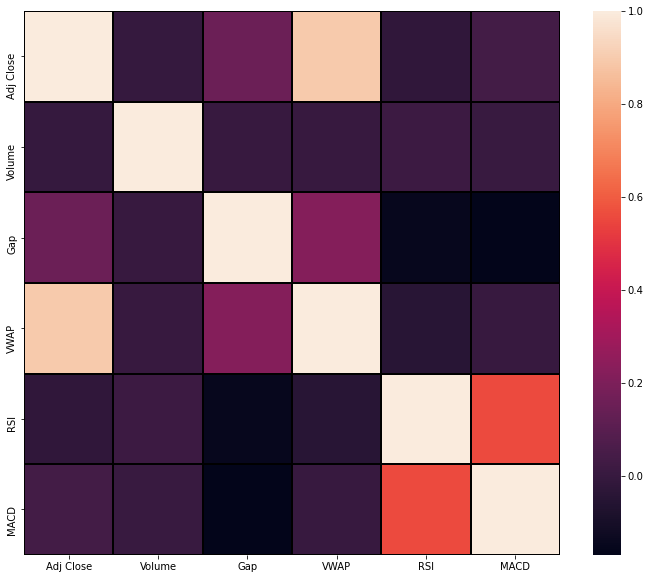

In [63]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(),linewidth=1,linecolor='black')

vwap와 rsi가 음의 상관관계를 띄는 것을 확인할 수 있다. 또한 gap은 volume과 양의 상관 관계를 띄는데 이로써 거래량이 튀면 고점이 증가한다는 것을 확인할 수 있다.

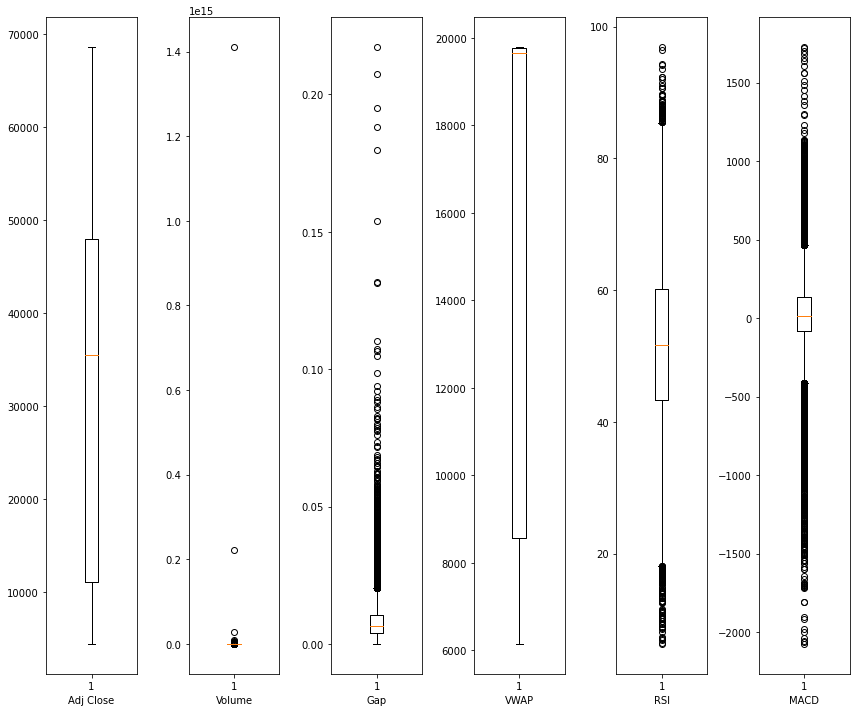

In [64]:
fig,axes = plt.subplots(1,6,figsize=(12,10))
for i, c in enumerate(df.columns,start=1):
    plt.subplot(1,6,i)
    plt.boxplot(df[c])
    plt.xlabel(c)
plt.tight_layout()

iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. gap, vwap, macd가 특히 심하다.


In [65]:
q_1 = df.apply(lambda x: np.quantile(x,0.25))
q_3 = df.apply(lambda x: np.quantile(x,0.75))
iqr = q_3 - q_1
min_p = q_1 - 2.5 * iqr
max_p = q_3 + 2.5 * iqr
print(min_p,max_p)

Adj Close   -8.104492e+04
Volume      -8.759104e+08
Gap         -1.215740e-02
VWAP        -1.940338e+04
RSI          1.234066e+00
MACD        -6.315205e+02
dtype: float64 Adj Close    1.401712e+05
Volume       1.226275e+09
Gap          2.688154e-02
VWAP         4.773275e+04
RSI          1.023608e+02
MACD         6.831415e+02
dtype: float64


5분 단위 데이터라 그런지 volume이 0으로 잡히는 경우가 많다. 따라서 volume을 제외하고 이상치를 구해준다.

In [66]:
outliers = np.where((df < min_p) | (df > max_p))
outliers

(array([   58,    71,    72, ..., 16962, 16962, 16963]),
 array([1, 2, 1, ..., 1, 5, 5]))

In [67]:
len(outliers[0])

2865

In [68]:
from collections import defaultdict
row,col = outliers
outliers_cols = defaultdict(list)
for r,c in zip(row,col):
    outliers_cols[df.columns[c]].append(r)
outliers_cols

defaultdict(list,
            {'Volume': [58,
              72,
              101,
              146,
              150,
              151,
              152,
              153,
              160,
              165,
              166,
              168,
              169,
              170,
              171,
              172,
              179,
              182,
              232,
              242,
              243,
              246,
              248,
              249,
              260,
              316,
              319,
              323,
              324,
              337,
              339,
              352,
              403,
              415,
              416,
              435,
              460,
              505,
              576,
              637,
              639,
              640,
              657,
              658,
              671,
              707,
              739,
              742,
              749,
              752,
              756,
     

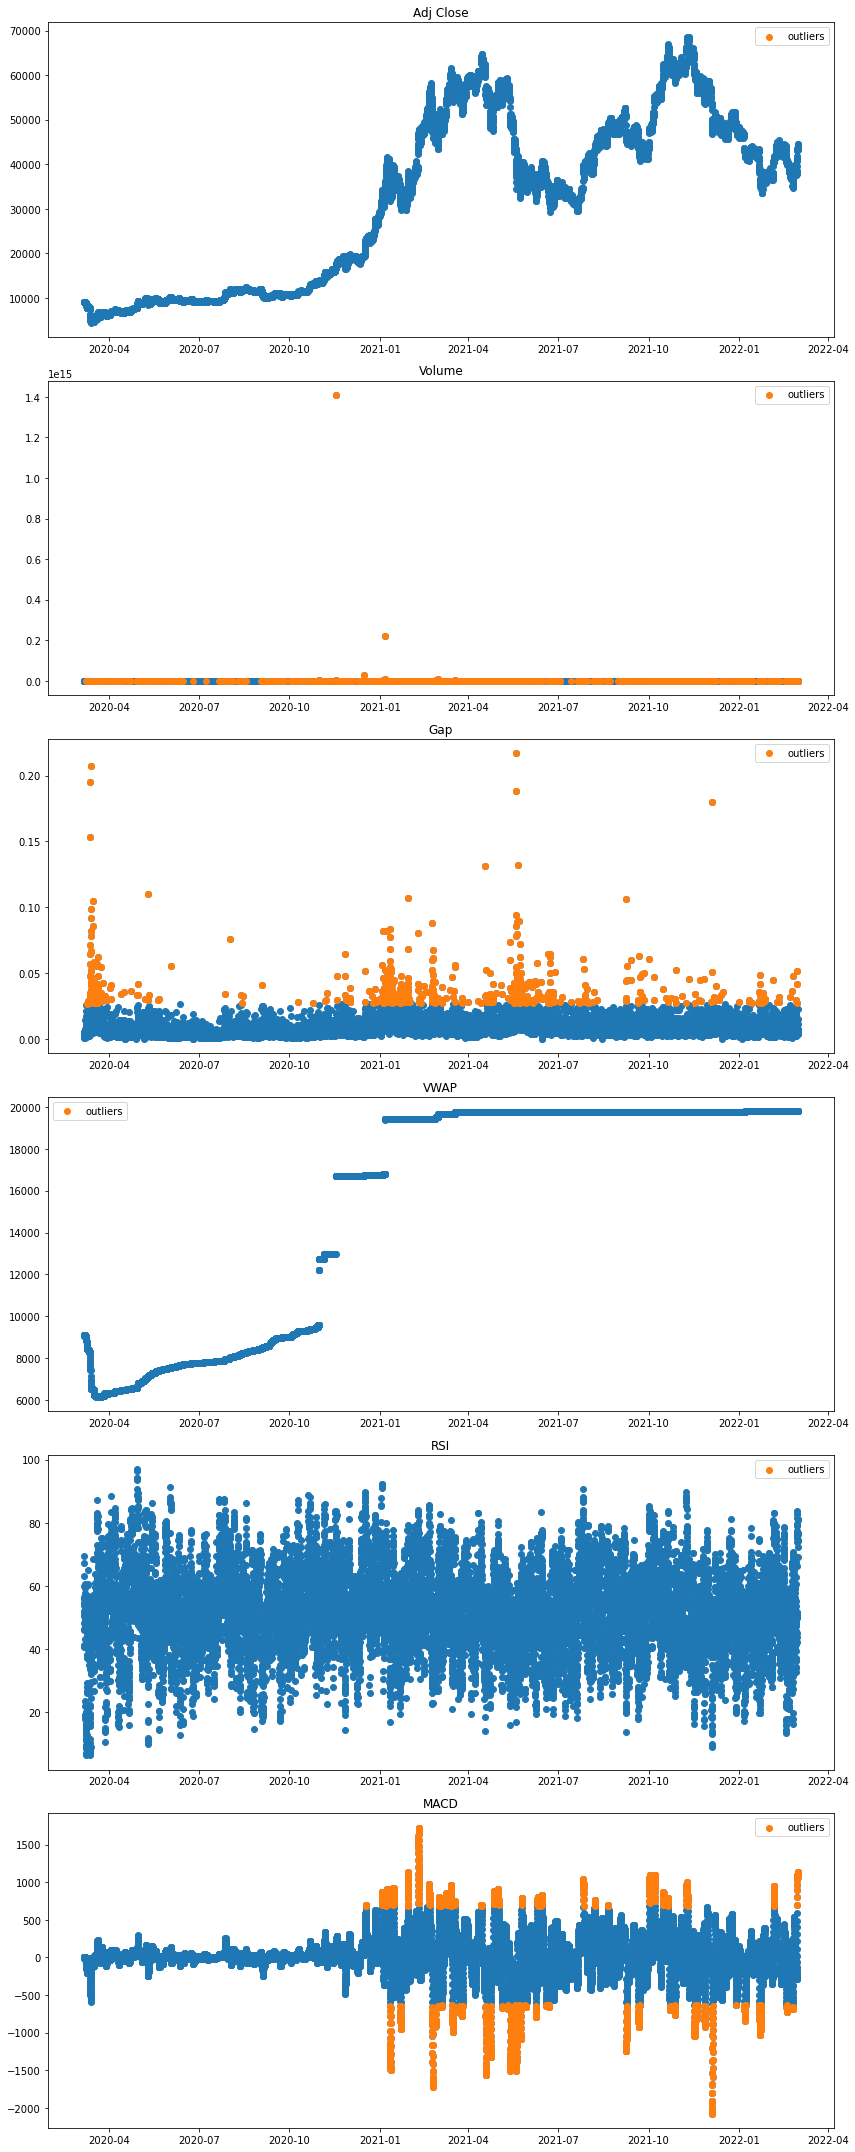

In [69]:
fig,axes = plt.subplots(6,1,figsize=(12,30))
for i, c in enumerate(df.columns,start=1):
    index = df[c].index
    plt.subplot(6,1,i)
    plt.title(c)
    plt.scatter(x=index,y=df[c])
    # if c!='Volume':
    plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
    plt.legend()
plt.tight_layout()

In [70]:
df = df.drop(df.index[row])
df

,Adj Close,Volume,Gap,VWAP,RSI,MACD
Date,,,,,,
2020-03-06 05:00:00,9100.071289,361533440.0,0.004717,9084.801055,53.776258,-4.959533
2020-03-06 06:00:00,9109.397461,97800192.0,0.003299,9085.905747,56.473186,-4.924357
2020-03-06 07:00:00,9108.590820,96886784.0,0.003117,9086.872084,56.167937,-4.451860
2020-03-06 08:00:00,9121.207031,354017280.0,0.003344,9091.496519,59.825530,-3.518598
2020-03-06 09:00:00,9134.069336,0.0,0.001660,9091.496519,63.197299,-2.132229
...,...,...,...,...,...,...
2022-02-28 17:00:00,41100.433594,856518656.0,0.006492,19785.551132,76.015813,116.449656
2022-02-28 18:00:00,41207.328125,856741888.0,0.004808,19785.561887,76.609931,213.850877
2022-02-28 19:00:00,41308.183594,0.0,0.005581,19785.561887,77.184195,308.541556


모델을 생성하고 비교해보자.

In [71]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Ridge(alpha=10,solver="cholesky",random_state=42))
])
lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=4, include_bias=True)),
    ('std_scaler', StandardScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])
rf_model = Pipeline([
    ('std_scaler', StandardScaler()),
    ('machine',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True))
])

In [72]:
def create_train_data(df):
    X = df.drop(['Adj Close','Volume'],axis=1)
    y = df['Adj Close'] #비트코인의 봉 평균가.
    train_X, test_X, train_y, test_y = train_test_split(X,y,test_size=0.3,random_state=24)
    return train_X, test_X, train_y, test_y

In [73]:
train_X, test_X, train_y, test_y = create_train_data(df)

In [74]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 52867829.77013917, alpha: 1000
mse: 50235227.11603045, alpha: 300
mse: 48815686.17994606, alpha: 100
mse: 47812711.05365856, alpha: 30
mse: 46841298.79657114, alpha: 10
mse: 44805924.291093394, alpha: 1
mse: 53166668.144598156, alpha: 1000
mse: 50294655.39154108, alpha: 300
mse: 49708579.097223334, alpha: 100


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 445243941.1824341, tolerance: 370673278.49554807
  model = cd_fast.enet_coordinate_descent(


mse: 48372394.03176226, alpha: 30


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46984353459.43042, tolerance: 370673278.49554807
  model = cd_fast.enet_coordinate_descent(


mse: 47408742.08716686, alpha: 10


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207916462855.72607, tolerance: 370673278.49554807
  model = cd_fast.enet_coordinate_descent(


mse: 46819080.523493, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 207916462855.72607, tolerance: 370673278.49554807
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=4)),
                ('std_scaler', StandardScaler()),
                ('regulator', Lasso(alpha=1, random_state=42))])

In [75]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse:.1f}')
    plt.legend()

In [76]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

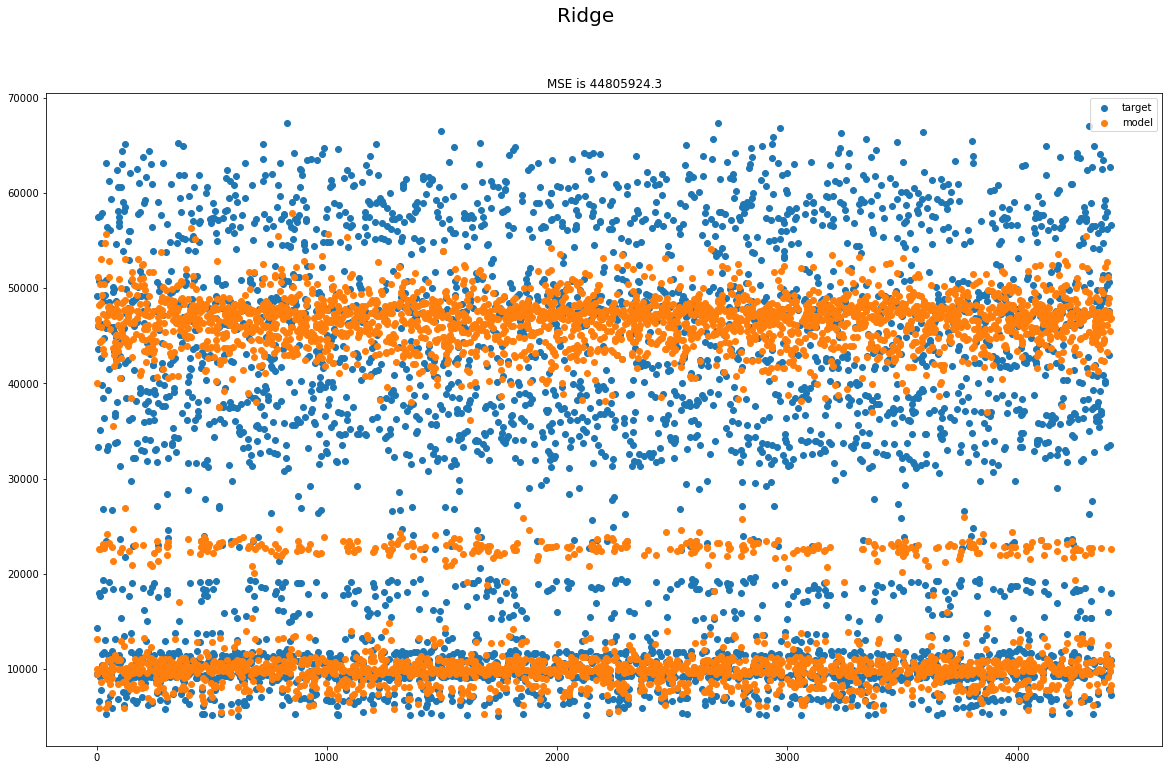

In [77]:
visualize(r_pred,test_y,"Ridge")

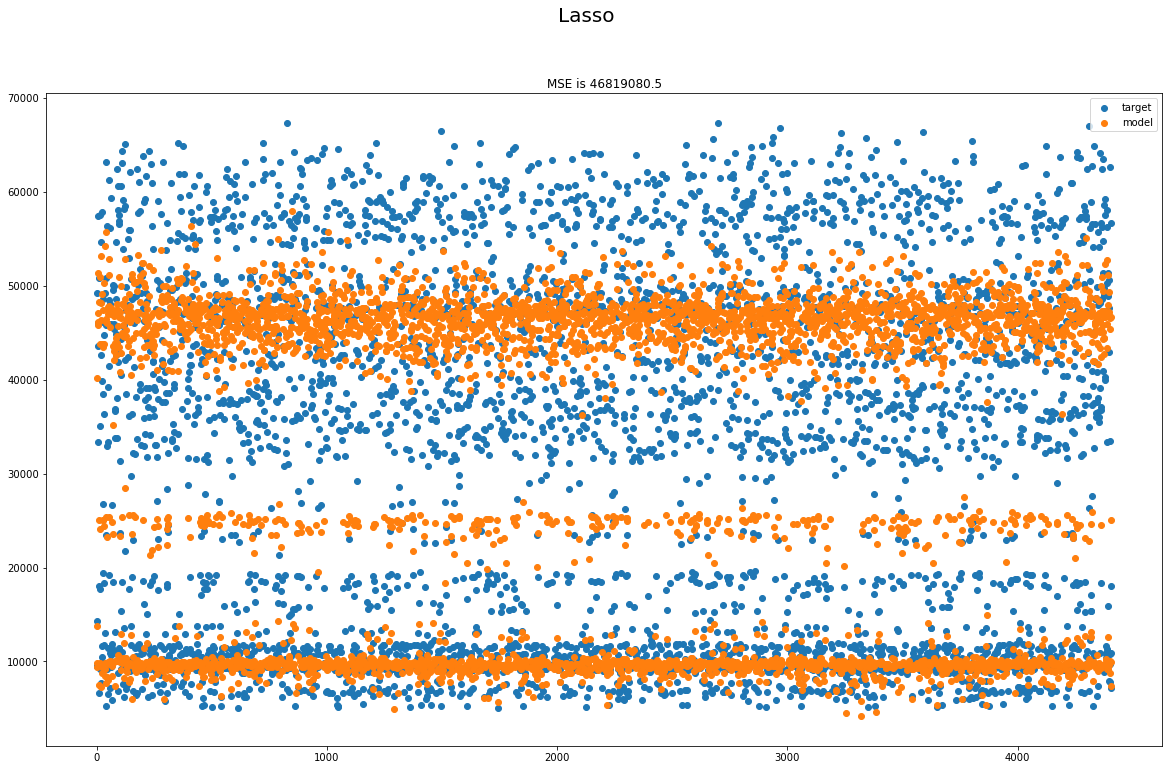

In [78]:
visualize(l_pred, test_y, "Lasso")

In [79]:
def visualize_plot(pred,target,name):
    pred = pd.Series(pred, index=target.index)
    plt.figure(figsize=(12,10))
    pred.sort_index().plot(label='model')
    test_y.sort_index().plot(label='target')
    plt.title(name)
    plt.legend()


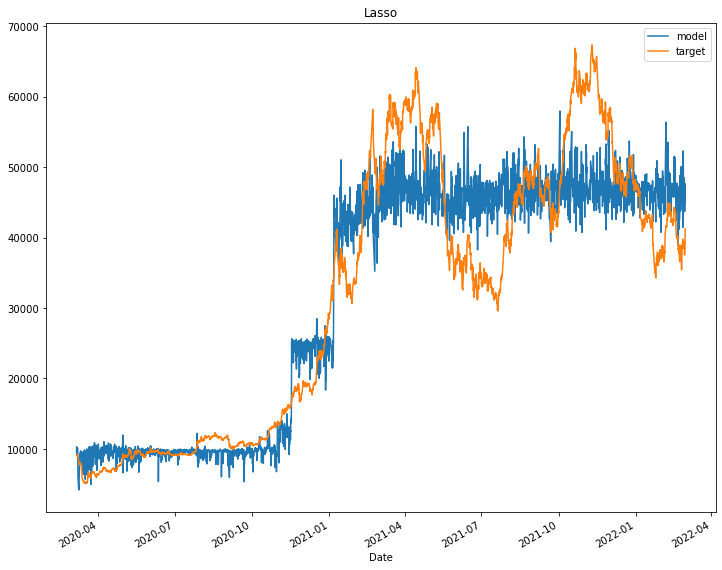

In [80]:
visualize_plot(l_pred, test_y, 'Lasso')

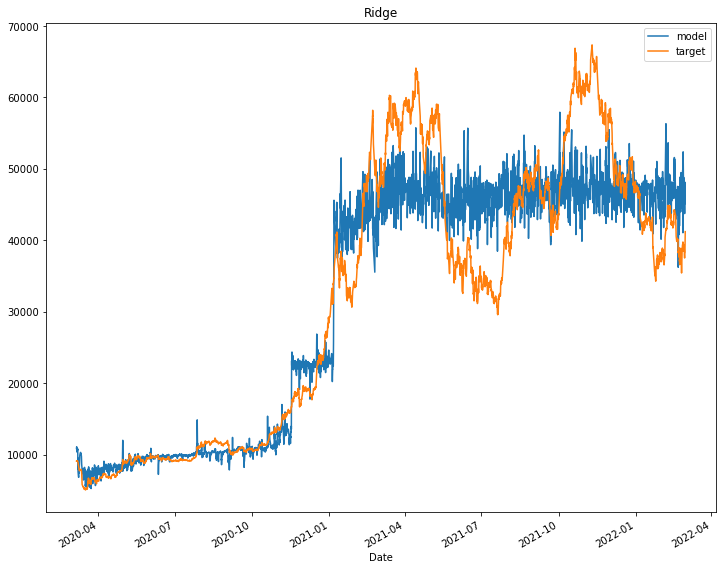

In [81]:
visualize_plot(r_pred, test_y, "Ridge")

In [82]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

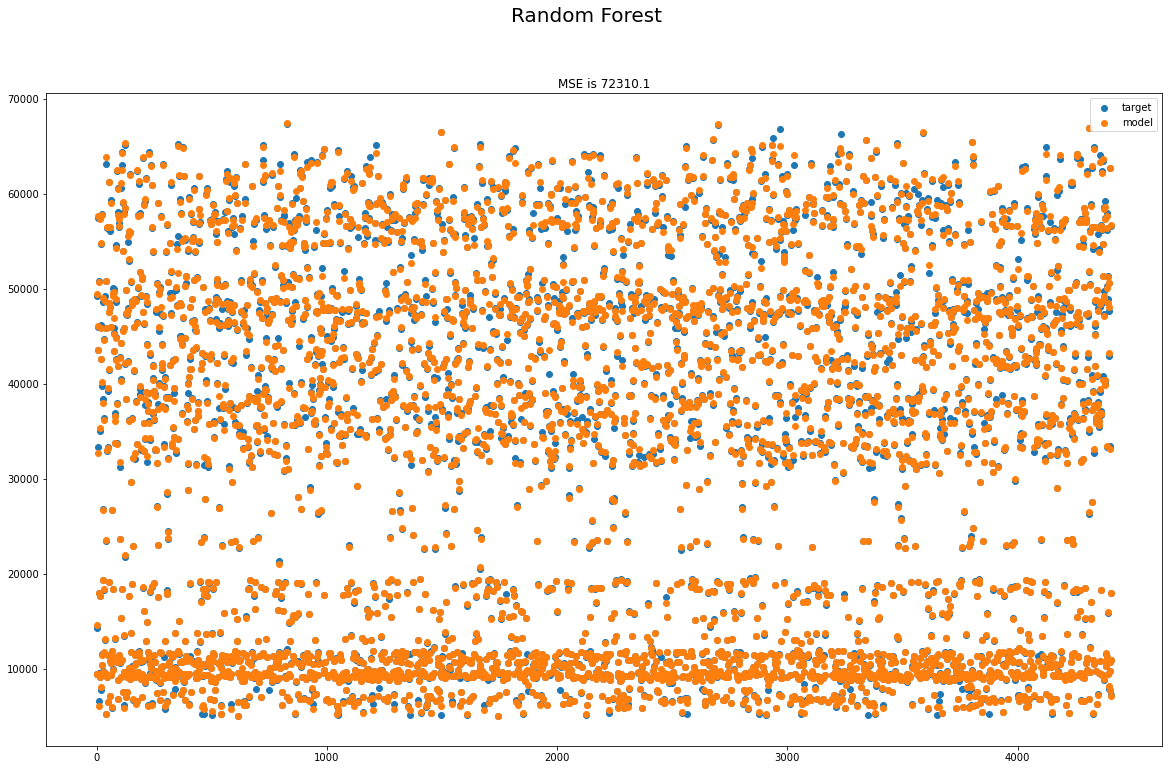

In [83]:
visualize(rf_pred, test_y, "Random Forest")

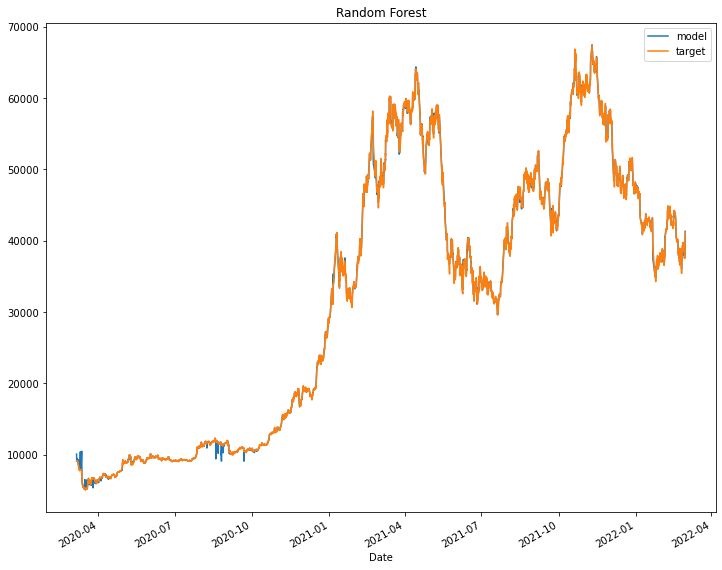

In [84]:
visualize_plot(rf_pred, test_y, "Random Forest")

In [85]:
from joblib import dump #모델을 저장한다.
dump(rf_model,'model/BTCUSD_RF_1h.joblib')


['model/BTCUSD_RF_1h.joblib']